# D05_Team5_Machine_Learning

In [2]:
# Import required libraries
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt 
import seaborn as sns 

from scipy.stats import norm

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
# Read data file
df = pd.read_excel('mpg.data.xlsx')
print(df.head())

    mpg  cylinders  displayments  horsepower  weight  acceleration  \
0  18.0          8         307.0       130.0    3504          12.0   
1  15.0          8         350.0       165.0    3693          11.5   
2  18.0          8         318.0       150.0    3436          11.0   
3  16.0          8         304.0       150.0    3433          12.0   
4  17.0          8         302.0       140.0    3449          10.5   

   model year  origin                   car name  Unnamed: 9  Unnamed: 10  \
0          70       1  chevrolet chevelle malibu         NaN          NaN   
1          70       1          buick skylark 320         NaN          NaN   
2          70       1         plymouth satellite         NaN          NaN   
3          70       1              amc rebel sst         NaN          NaN   
4          70       1                ford torino         NaN          NaN   

   Unnamed: 11 Unnamed: 12  
0          NaN         NaN  
1          NaN         NaN  
2          NaN         NaN  


# Handling missing values

In [4]:
# Drop empty columns
df = df.drop(columns=[col for col in df if col.startswith('Unnamed:')])

In [5]:
# Check for missing values
print('Attributes\tMissing values')
print(df.isna().sum())

Attributes	Missing values
mpg             8
cylinders       0
displayments    0
horsepower      6
weight          0
acceleration    0
model year      0
origin          0
car name        0
dtype: int64


#### In order to fill the missing values, we calculated the correlation between columns

In [6]:
df.corr(method='pearson', min_periods=1)

,mpg,cylinders,displayments,horsepower,weight,acceleration,model year,origin
mpg,1.000000,-0.775396,-0.804203,-0.778427,-0.831741,0.420289,0.579267,0.563450
cylinders,-0.775396,1.000000,0.951787,0.844158,0.895220,-0.522452,-0.360762,-0.567478
displayments,-0.804203,0.951787,1.000000,0.898326,0.932475,-0.557984,-0.381714,-0.613056
horsepower,-0.778427,0.844158,0.898326,1.000000,0.866586,-0.697124,-0.424419,-0.460033
weight,-0.831741,0.895220,0.932475,0.866586,1.000000,-0.430086,-0.315389,-0.584109
acceleration,0.420289,-0.522452,-0.557984,-0.697124,-0.430086,1.000000,0.301992,0.218845
model year,0.579267,-0.360762,-0.381714,-0.424419,-0.315389,0.301992,1.000000,0.187656
origin,0.563450,-0.567478,-0.613056,-0.460033,-0.584109,0.218845,0.187656,1.000000


In [7]:
# The most effective approach was when we dropped rows with missing 'mpg' values

print(f'Rows before dropping missing "mpg" values: {len(df)}')

df = df[df['mpg'].notna()]

print(f'Remaining rows after dropping missing "mpg" values : {len(df)}')

Rows before dropping missing "mpg" values: 406
Remaining rows after dropping missing "mpg" values : 398


Note: Observing correlation matrix we notice that 'horsepower' has high correlation with 'displayments', so we fill the missing values accordingly.

In [8]:
# Horsepower replacement 

def replace_na_correlated_values(df, col1, col2):
    """ For missing values, calculate mean horsepower of cars with similar displacement """
    b=[]
    for val in df[df[col1].isna()][col2]:
       b.append(df[(df[col2] > val - df[col2].std())
                & (df[col2] < val + df[col2].std())][col1].mean())
    return(b)

df.loc[df['horsepower'].isna(), 'horsepower'] = replace_na_correlated_values(df, 'horsepower', 'displayments')

In [9]:
# Making sure there are no missing values
print('Attributes\tMissing values')
df.isna().sum()

Attributes	Missing values


mpg             0
cylinders       0
displayments    0
horsepower      0
weight          0
acceleration    0
model year      0
origin          0
car name        0
dtype: int64

# Handling Outliers

In [10]:
# Perform IQR score technique to find outliers
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

print(IQR)

mpg               11.50
cylinders          4.00
displayments     157.75
horsepower        49.00
weight          1384.25
acceleration       3.35
model year         6.00
origin             1.00
dtype: float64


*Note 1: Checking on the kind of dataset we are facing (a dataset regarding cars), we concluded that even if it seems that there are some outliers, for our problem it does not seem like they should be excluded.*

*Note 2: In addition, keeping outliers led to increasing model performance.*

# Rename Columns

In [11]:
## Rename Columns
df = df.rename(columns={'displayments': 'Displacement'})
df = df.rename(columns={'mpg': 'Mpg'})
df = df.rename(columns={'cylinders': 'Cylinders'})
df = df.rename(columns={'horsepower': 'Horsepower'})
df = df.rename(columns={'weight': 'Weight'})
df = df.rename(columns={'acceleration': 'Acceleration'})
df = df.rename(columns={'model year': 'Model Year'})
df = df.rename(columns={'origin': 'Origin'})
df = df.rename(columns={'car name': 'Car Name'})

In [12]:
# Due to the fact that 'car name' could not provide  much information to our model, 
# the company that manifactured each car was extracted as a new column.
 
company = []

for car in df['Car Name']:
    car= car.split(" ")
    company.append(car[0])
df['Company'] = company

correct_names = {
    'chevy': 'chevrolet', 'toyouta': 'toyota', 'maxda': 'mazda',
    'chevroelt': 'chevrolet', 'vw': 'volkswagen', 'mercedes-benz': 'mercedes',
    'vokswagen': 'volkswagen'
}
df['Company'].replace(correct_names, inplace=True)

# At this point 'Car Name' has no value for us, so it is dropped from our dataframe.
df=df.drop(columns=['Car Name'])

# Encoding features

In [13]:
# One-hot encode the two categorical features: 'Origin', 'Company'
df = pd.get_dummies(df, columns=['Origin', 'Company'])

# Transformation of our target variable

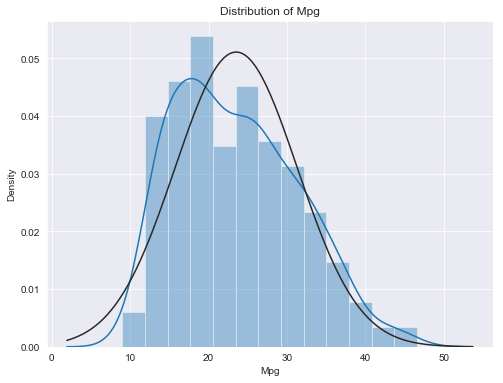

skewness 0.45706634399491913
kurtosis -0.5107812652123154


In [14]:
# Distribution of our target value before transformation
sns.set_style('darkgrid')
plt.figure(figsize=(8,6))
sns.distplot(df.Mpg, fit=norm)
plt.title('Distribution of Mpg')
plt.show()

print(f'skewness {df.Mpg.skew()}')
print(f'kurtosis {df.Mpg.kurtosis()}')

In [15]:
# Transformation of our target value with log(1+Y) function
df['Mpg'] = np.log1p(df['Mpg'])

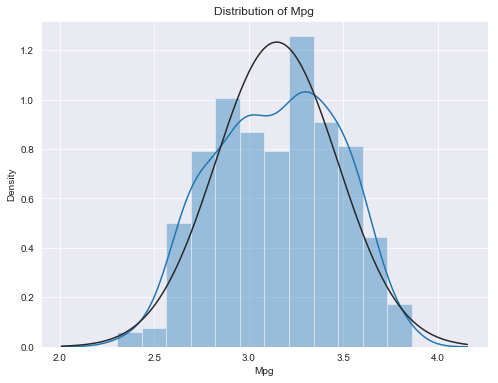

skewness -0.10913831720100581
kurtosis -0.8190698810879078


In [16]:
# Distribution of our target value after transformation
sns.set_style('darkgrid')
plt.figure(figsize=(8,6))
sns.distplot(df.Mpg, fit=norm)
plt.title('Distribution of Mpg')
plt.show()

print(f'skewness {df.Mpg.skew()}')
print(f'kurtosis {df.Mpg.kurtosis()}')

*Important Note: By using log(1+Y) instead of Y, we achieve better performance in our prediction model. This is due to the fact that we achieve the enhancement of distribution of the Mpg, more specifically we enhance the skewness of the distribution.*

In [17]:
print(f'Number of total columns: {len(df.columns)}')

# Check which of the encoded variables('Origin' and 'Company') can actually give information.
# To achieve that we keep the encoded columns that have values at, at least 3% of total rows.

useless_cols = [col for col in df.columns if df[col].nunique() == 2 
                and ((df[col].value_counts()/len(df)) < 0.03).any(axis=None)]

print(f'Number of useless columns: {len(useless_cols)}')

df.drop(useless_cols, axis=1, inplace=True)

print(f'Number of remaining columns: {len(df.columns)}')

Number of total columns: 40
Number of useless columns: 18
Number of remaining columns: 22


In [19]:
df.to_excel('mpg.preprocessed.xlsx', index=False)